In [1]:
%pylab inline
import pandas as pd
from collections import deque

Populating the interactive namespace from numpy and matplotlib


In [2]:
price = pd.read_csv('price_data.csv', index_col=0)
price = price.fillna(method='pad')
price.index = pd.to_datetime(price.index)
price.columns = ['CL', 'GC','ES','TY']

oi = pd.read_csv('OI_data.csv',index_col=0)
oi = oi.fillna(method='pad')
oi.index = pd.to_datetime(oi.index)
oi.columns = ['CL', 'GC','ES','TY']

In [3]:
class PainTradeMonitor(object):
    def __init__(self, price_series, oi_series):
        self.std_look_back = 252
        self.signal_look_back = 30
        self.composite = self._make_DataFrame(price_series, oi_series)
        # processed DataFrame, which contains fields (aligned by date):
        # 'price', 'oi', 'oi change', 'price change', 
        # 'ls', 'offside', 'caught_offside'
        self.length = len(self.composite)
        self.processed = None
        self.buy_hold_pnl = 1/price_series[0]*price_series[-1] - 1
    
    def _make_DataFrame(self, price_series, oi_series):
        temp = pd.concat([price_series,
                          oi_series, 
                          price_series.diff(1)[1:],
                          oi_series.diff(1)[1:]
                         ], 
                         join='inner', axis=1)
        temp.columns = ['price', 'oi', 'price change', 'oi change']
        return temp
    
    def new_ls(self, start, end):
        ''' (DataFrame with 'oi change', int, int) -> double of pct_change
        According to the first assumption, we have four cases:
        1. price + and oi +: new longs
        2. price + and oi -: old shorts covered
        3. price - and oi +: new shorts
        4. price - and oi -: old long taken off
        Note since we are only looking at new long vs new shorts, long position
        taken off and short position covering from outside 30-day is not considered.
        i.e. long_ and short_ always floored by 0
        '''
        long_ = 0.
        short_ = 0.
        for i in range(start, end):
            oi_change = self.composite['oi change'][i]
            price_change = self.composite['price change'][i]
            if price_change > 0 and oi_change > 0: # case 1
                long_ += oi_change
            elif price_change > 0 and oi_change < 0: # case 2
                short_ += oi_change
                short_ = max(short_, 0)
            elif price_change < 0 and oi_change > 0: # case 3
                short_ += oi_change
            else: # case 4
                long_ += oi_change
                long_ = max(long_, 0)
        
        return (long_-short_)/self.composite['oi'][end-1]

    def oi_change_at_prices(self, start, end):
        ''' (int of index, int of index) -> (d_l, d_s)
        The long/short side oi are computed according to the 3rd assumption in paper, 
        which states offset position covers previous positions proportionally, with the 
        ratio equal to the ratio of offest position to current previous positions.
        e.g. {40:100, 50:200}
        if today's close is 45 and oi decreased by 150, then ratio = 150/(100+200) = 1/2,
        new positions will be {40:50, 50:100};
        if oi decreased by 400, then ratio > 1, all previous long in the monitor window
        are taken off, the excess is from the older long taken off. Thus, new position
        will be  {40:0, 50:0} or simply {}

        Return a tuple of (d_l, d_s)
        '''
        pos_l = 0.
        pos_s = 0.
        d_l = {}
        d_s = {}
        for i in range(start, end):
            oi_change = self.composite['oi change'][i]
            price_change = self.composite['price change'][i]
            price = self.composite['price'][i]
            
            if oi_change > 0:
                if price_change > 0: # +long
                    pos_l += oi_change
                    if price not in d_l:
                        d_l[price] = oi_change
                    else:
                        d_l[price] += oi_change
                else: # +short
                    pos_s += oi_change
                    if price not in d_s:
                        d_s[price] = oi_change
                    else:
                        d_s[price] += oi_change
            else:
                if price_change > 0: # -short
                    if pos_s == 0 or abs(oi_change) > pos_s:
                        d_s = {}
                        pos_s = 0
                    else:
                        for key in d_s:
                            d_s[key] = (1-abs(oi_change)/pos_s)*d_s[key]
                        pos_s += oi_change
                else: # -long
                    if pos_l == 0 or abs(oi_change) > pos_l:
                        d_l = {}
                        pos_l = 0
                    else:
                        for key in d_l:
                            d_l[key] = (1-abs(oi_change)/pos_l)*d_l[key]
                        pos_l += oi_change
        return d_l, d_s

    def offside_pnl(self, start, end, last_close=None):
        '''(int of index, int of index, double of last close price) -> double of pnl
        All PnL's are positive numbers in this function, but it represents offside 
        loss.
        If long PnL > short PnL, price will decrease by longs taken off
        if long PnL < short PnL, price will increase by covering shorts
        Return ( pnl_l - pnl_s )
        '''
        d_l, d_s = self.oi_change_at_prices(start, end)
        if last_close is None:
            last_close = self.composite['price'][end-1]
        
        pnl_l = sum([d_l[key]*key for key in d_l if key > last_close])
        pnl_s = sum([d_s[key]*key for key in d_s if key < last_close])
        
        return pnl_l - pnl_s

    def caught_offside(self, start, end):
        ''' (int of index, int of index) -> double of pnl caught offside
        New difference of long vs short PnL (pnl_l - pnl_s) minus the old difference
        will give us the new PnL difference caught offside.
        Similar to offside_pnl, positive means price will decrease, negative means
        price will increase
        '''
        sig = self.return_std(end-252, end)
        last_close = self.composite['price'][end-1]
        d_l, d_s = self.oi_change_at_prices(start, end)
        # current
        cur_l = sum([d_l[key]*key for key in d_l if key > last_close])
        cur_s = sum([d_s[key]*key for key in d_s if key < last_close])
        
        # exposed longside PnL if price down 2*sig
        move_l = sum([d_l[key]*key for key in d_l if key > last_close*(1-2*sig)])
        move_s = sum([d_s[key]*key for key in d_s if key < last_close*(1+2*sig)])
        
        return (move_l-cur_l) - (move_s-cur_s)

    def get_signal_list(self, factor_func):
        ''' (function of a factor) -> list of z-score signals
        '''
        std_, queue, s1, s2 = self.factor_std(factor_func, 0, self.std_look_back)
        res = [queue[-1]/std_]
        m = float(self.std_look_back)
        n = float(self.std_look_back + 1 - self.signal_look_back)
        for i in range(self.std_look_back+1, self.length+1):
            factor1 = queue.popleft()
            factor = factor_func(i-self.signal_look_back, i)
            s1 = s1-factor1+factor
            s2 = s2-factor1*factor1+factor*factor
            std_ = sqrt(s2/n - s1*s1/n/n)
            queue.append(factor)
            res.append(factor/std_)
        return res

    def factor_std(self, factor_func, start, end):
        ''' (function, int, int) -> double of std, deque, double, double
        Calculate the std of a factor, also returns a queue of factors used to 
        calculate std, s1 and s2 are sums of these factors and square factors, 
        to improve get_signal_list speed.
        '''
        s2 = 0
        s1 = 0
        factor1 = deque([])
        n = float(end+1 - start - self.signal_look_back)
        for i in range(start+self.signal_look_back, end+1): # i is the first outside
            factor = factor_func(i-self.signal_look_back, i)
            s2 += factor*factor
            s1 += factor
            factor1.append(factor)
        return sqrt(s2/n-s1*s1/n/n), factor1, s1, s2

    def long_short(self, field_name, threshold):
        ''' (DataFrame, string, double of threshold to trade) -> double
        Return percentage of pnl in decimal number of signal input from field_name.
        This strategy place 100% long/short position in short/long signal extremes if 
        no current position if the signal moves beyond the threshold. It flatten its 
        position at first reverse signal and do nothing if already has a position and 
        encounter the same type of signal. Note this treats the end of data as the 
        terminal period and clear all existing position.
        '''
        pnl = 0
        pos = [0,0]
        score = self.processed[field_name] # z-score
        price = self.processed['price']
        for i in range(len(score)):
            if score[i] > threshold:
                # do nothing if pos < 0 as its short position already
                if pos[0] == 0:
                    pos[0], pos[1] = -1/price[i], price[i] # take on short position
                elif pos[0] > 0: # we have long position, time to sell
                    pnl += pos[0]*(price[i] - pos[1])
                    pos = [0,0]
            elif -score[i] > threshold:
                if pos[0] == 0:
                    pos[0], pos[1] = 1/price[i], price[i] # take on long position
                elif pos[0] < 0: # we have short position, time to cover
                    pnl += pos[0]*(price[i] - pos[1])
                    pos = [0,0]
        if pos != [0,0]: # if still have position, clear
            pnl += pos[0]*(price[-1]-pos[1])
        return pnl
    
    def long_only(self, field_name, threshold):
        '''(DataFrame, string of signal name, double of threshold to trade) -> double
        A long only strategy, which buy at short extremes and sell at long extremes.
        '''
        pnl = 0
        pos = [0, 0]
        score = self.processed[field_name] # z-score
        price = self.processed['price']
        for i in range(len(score)):
            if score[i] > threshold and pos[0] > 0: # have long position, time to sell
                pnl += pos[0]*(price[i] - pos[1])
                pos = [0,0]
            elif -score[i] > threshold and pos[0] == 0:
                pos[0], pos[1] = 1/price[i], price[i] # take on long position
        if pos != [0,0]: # if still have position, clear
            pnl += pos[0]*(price[-1]-pos[1])
        return pnl
    
    def short_only(self, field_name, threshold):
        ''' (DataFrame, string of signal name, double of threshold to trade) -> double
        A short only strategy, which sell at long extremes and buy at long extremes.
        '''
        pnl = 0
        pos = [0,0]
        score = self.processed[field_name] # z-score
        price = self.processed['price']
        for i in range(len(score)):
            if score[i] > threshold and pos[0] == 0:
                    pos[0], pos[1] = -1/price[i], price[i] # take on short position
            elif -score[i] > threshold and pos[0] < 0: # have short pos, time to cover
                    pnl += pos[0]*(price[i] - pos[1])
                    pos = [0,0]
        if pos != [0,0]: # if still have position, clear
            pnl += pos[0]*(price[-1]-pos[1])
        return pnl

    def return_std(self, start, end):
        ''' (int of index, int of index) -> double of daily log return volatility
        '''
        ret = log(self.composite['price'][start:end])
        ret = ret.diff(1)
        return std(ret)

    def get_sharpe_ratio(self, ret):
        ''' (double of annualized log return) -> double of Sharpe ratio
        Given annualized log return, compute Sharpe ratio over the whole data period
        '''
        return ret / (self.return_std(0,self.length)*sqrt(252))
    
    def process(self):
        '''
        Compute all three signals and produce and store a DataFrame with fields 'price',
        'oi', 'oi change', 'ls', 'offside', 'caught_offside' in self.processed attribute
        '''
        signal_1 = pd.DataFrame(self.get_signal_list(self.new_ls),
                               columns = ['ls'],
                               index = self.composite.index[self.std_look_back-1:])
        signal_2 = pd.DataFrame(self.get_signal_list(self.offside_pnl),
                               columns = ['offside'],
                               index = self.composite.index[self.std_look_back-1:])
        signal_3 = pd.DataFrame(self.get_signal_list(self.caught_offside),
                               columns = ['caught_offside'],
                               index = self.composite.index[self.std_look_back-1:])
        self.processed = pd.concat([self.composite, signal_1, signal_2, signal_3], 
                                  join='inner', axis=1)

## Some Demos

In [4]:
# This block will take about 1min to run
# process() computes all three signals and compile them along with the original data
cl = PainTradeMonitor(price['CL'], oi['CL'])
gc = PainTradeMonitor(price['GC'], oi['GC'])
es = PainTradeMonitor(price['ES'], oi['ES'])
ty = PainTradeMonitor(price['TY'], oi['TY'])
cl.process()
gc.process()
es.process()
ty.process()

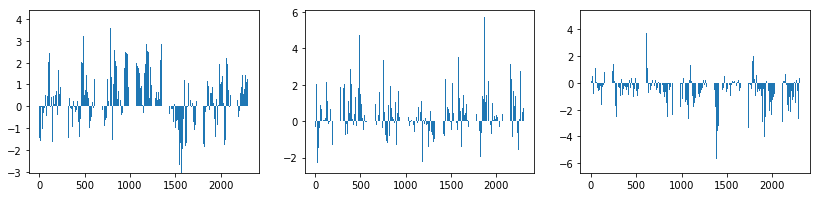

In [5]:
# some sample plots of signals
# plot bar chart needs more time (about 30s) than plot line, uncomment to plot line
fig, ax = subplots(ncols=3, nrows=1, figsize=[14,3])
ax[0].bar(arange(len(cl.processed['ls'])), cl.processed['ls']);
ax[1].bar(arange(len(gc.processed['offside'])), gc.processed['offside']);
ax[2].bar(arange(len(es.processed['caught_offside'])), es.processed['caught_offside']);
# fig, ax = subplots(ncols=3, nrows=1, figsize=[14,3])
# ax[0].plot(cl.processed['ls']);
# ax[1].plot(gc.processed['offside']);
# ax[2].plot(es.processed['caught_offside']);

In [6]:
assets = [cl, gc, es, ty]
signal_names = ['ls', 'offside', 'caught_offside']
for asset in assets:
    print '--------------------Passive Sharpe Ratio', \
    round(asset.get_sharpe_ratio(log(1+asset.buy_hold_pnl)*252/float(asset.length)), 2), \
    '--------------------'
    for signal in signal_names:
        print 'Strategy', signal+':', 'Long Short at Threshold 2: ', \
        round(asset.get_sharpe_ratio(asset.long_short(signal, 2)*252/float(asset.length)), 2)
        print 'Strategy', signal+':', 'Long Only at Threshold 2: ', \
        round(asset.get_sharpe_ratio(asset.long_only(signal, 2)*252/float(asset.length)), 2)
        print 'Strategy', signal+':', 'Short Only at Threshold 2: ', \
        round(asset.get_sharpe_ratio(asset.short_only(signal, 2)*252/float(asset.length)), 2)
    print '-------------------------------------------------------------------\n'

--------------------Passive Sharpe Ratio -0.14 --------------------
Strategy ls: Long Short at Threshold 2:  -0.02
Strategy ls: Long Only at Threshold 2:  0.0
Strategy ls: Short Only at Threshold 2:  -0.06
Strategy offside: Long Short at Threshold 2:  -0.21
Strategy offside: Long Only at Threshold 2:  0.01
Strategy offside: Short Only at Threshold 2:  -0.13
Strategy caught_offside: Long Short at Threshold 2:  0.11
Strategy caught_offside: Long Only at Threshold 2:  0.06
Strategy caught_offside: Short Only at Threshold 2:  -0.05
-------------------------------------------------------------------

--------------------Passive Sharpe Ratio 0.21 --------------------
Strategy ls: Long Short at Threshold 2:  -0.17
Strategy ls: Long Only at Threshold 2:  0.03
Strategy ls: Short Only at Threshold 2:  -0.22
Strategy offside: Long Short at Threshold 2:  -0.07
Strategy offside: Long Only at Threshold 2:  0.16
Strategy offside: Short Only at Threshold 2:  -0.19
Strategy caught_offside: Long Short a

### Asset CL
| Passive Sharpe Ratio |
|------------|
| -0.14         |  



|  | long short | long |   short    | 
|------------|-------|-------|-------| 
| ls         | -0.02 | 0  | -0.06  | 
| offside    | -0.21 | -0.01 | -0.13  | 
| caught     | 0.11 | 0.06 | -0.05 | 

&nbsp;
&nbsp;



### Asset GC
| Passive Sharpe Ratio |
|------------|
| 0.21         | 

|  | long short | long |   short    | 
|------------|------|-------|-------| 
| ls         | -0.17 | 0.03  | -0.22  | 
| offside    | -0.07 | 0.16  | -0.19 | 
| caught     | -0.47    | -0.07  | -0.4 | 

&nbsp;
&nbsp;



### Asset ES
| Passive Sharpe Ratio |
|------------|
| 0.78 | 

|  | long short | long |   short    | 
|------------|------|-------|-------| 
| ls         | -0.25  | 0  | -0.25  | 
| offside    | 0.21 | 0.23  | -0.02 | 
| caught     | 0.32  | 0.29  | 0.03 | 
&nbsp;
&nbsp;





### Asset TY
| Passive Sharpe Ratio |
|------------|
| 0.14 | 

|  | long short | long |   short    | 
|------------|-------|-------|-------| 
| ls         | -0.2 | -0.13 | -0.15 | 
| offside    | -0.31  | -0.13  | -0.15  | 
| caught     | -0.15 | -0.04 | -0.07 | 

&nbsp;
&nbsp;






In [7]:
# can directly get new_ls, oi_change_at_prices, offside_pnl, and caught_offside stats
# between interested period

# new short/long positions as percentage to current oi
cl.new_ls(cl.length-252, cl.length)  

0.1423507671184763

In [8]:
# open interest at price levels (long, short)
cl.oi_change_at_prices(cl.length-30, cl.length)

({52.469999999999999: 3054.3033278274797,
  52.640000000000001: 7754.2423973102377,
  53.899999999999999: 17650.100396589169,
  54.149999999999999: 12024.332254521369,
  54.380000000000003: 7180.2622854603542,
  54.539999999999999: 27.130522273554295,
  55.640000000000001: 10384.207400202908,
  57.170000000000002: 25561.191125793386,
  57.350000000000001: 17482.230290021551},
 {52.18: 14744.033398283933,
  54.299999999999997: 4808.5915632584683,
  56.090000000000003: 66.0,
  56.740000000000002: 10574.664000273475,
  56.810000000000002: 2386.9403138139674,
  57.200000000000003: 7046.7707243701498})

In [9]:
# the offside pnl compared to last close
cl.offside_pnl(cl.length-30, cl.length)

1433489.0191869535

In [10]:
# the pnl caught offside if last close moves 2 std
cl.caught_offside(cl.length-30, cl.length)

-172666.07852183748

In [11]:
# check original data
cl.composite.head(5)

,price,oi,price change,oi change
2008-01-03,99.18,1413302.0,-0.44,31102.0
2008-01-04,97.91,1418444.0,-1.27,5142.0
2008-01-07,95.09,1405234.0,-2.82,-13210.0
2008-01-08,96.33,1413956.0,1.24,8722.0
2008-01-09,95.67,1423139.0,-0.66,9183.0


In [12]:
# passive pnl
cl.buy_hold_pnl

-0.43184099578397916

In [13]:
# processed DataFrame is directly accessible
cl.processed.head(5)

,price,oi,price change,oi change,ls,offside,caught_offside
2008-12-22,39.91,1135539.0,6.04,3128.0,-1.576129,0.000000,-0.166149
2008-12-23,38.98,1133973.0,-0.93,-1566.0,-1.445355,0.038676,-0.242374
2008-12-24,35.35,1142552.0,-3.63,8579.0,-1.361243,0.038676,-0.188122
2008-12-26,37.71,1146031.0,2.36,3479.0,-1.291056,-0.149462,-0.087474
2008-12-29,40.02,1164760.0,2.31,18729.0,-0.911351,-0.188112,0.346217


In [14]:
# given annual log return, get sharpe ratio
cl.get_sharpe_ratio(.05)

0.12834273084196093

In [15]:
# get factor std
print 'ls std within last 252 days is', cl.factor_std(cl.new_ls, cl.length-252, cl.length)[0]

print 'offside_pnl std within last 252 days is', \
cl.factor_std(cl.offside_pnl, cl.length-252, cl.length)[0]

print 'caught_offside std within last 252 days is', \
cl.factor_std(cl.caught_offside, cl.length-252, cl.length)[0]

ls std within last 252 days is 0.0345379524344
offside_pnl std within last 252 days is 2646747.58933
caught_offside std within last 252 days is 1989590.17949


In [16]:
# can modify the signal_look_back to change monitor window
cl.signal_look_back = 10
print 'ls std within last 252 days, after monitor window changed to 10 days', \
cl.factor_std(cl.new_ls, cl.length-252, cl.length)[0]

ls std within last 252 days, after monitor window changed to 10 days 0.0197496280745


In [17]:
cl.signal_look_back = 30 # change back

In [18]:
# similarly can modify std_look_back adjust z-score denominator std period, 
# such as quarterly

# cl.std_look_back = 252/4